In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.io.wavfile import write
import librosa
import librosa.display

def generate_smoothed_noise(size=256):
    noise = np.random.rand(size, size)
    smooth = gaussian_filter(noise, sigma=10)
    cv2.imwrite('smoothed_noise.png', (smooth * 255).astype(np.uint8))
    return 'smoothed_noise.png'

def generate_am_signal(fs=44100, duration=5):
    t = np.linspace(0, duration, int(fs * duration))
    carrier = np.sin(2 * np.pi * 1000 * t)
    modulator = (1 + np.sin(2 * np.pi * 5 * t)) / 2
    y = carrier * modulator
    output_filename = 'am_signal.wav'
    write(output_filename, fs, (y * 32767).astype(np.int16))
    return output_filename

image_path = generate_smoothed_noise()
audio_path = generate_am_signal()

print(f"Generated image: {image_path}")
print(f"Generated audio: {audio_path}")

Generated image: smoothed_noise.png
Generated audio: am_signal.wav


In [11]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Image not found. Check the file path.")

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f) 

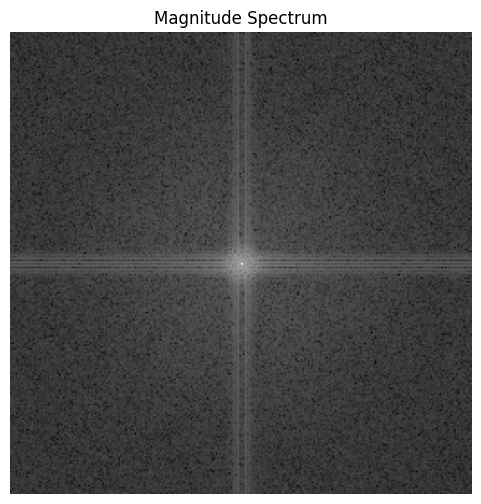

In [12]:

magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

In [13]:
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

mask_lp = np.zeros((rows, cols), np.uint8)
r_lp = 50 
cv2.circle(mask_lp, (ccol, crow), r_lp, 1, thickness=-1)

mask_hp = 1 - mask_lp

fshift_lp = fshift * mask_lp
fshift_hp = fshift * mask_hp

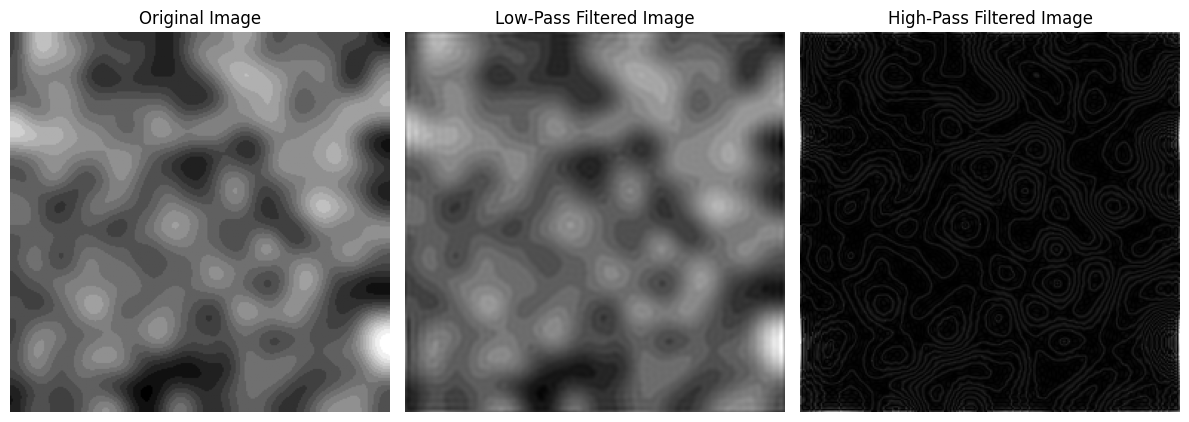

In [14]:
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)

f_ishift_hp = np.fft.ifftshift(fshift_hp)
img_back_hp = np.fft.ifft2(f_ishift_hp)
img_back_hp = np.abs(img_back_hp)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_back_lp, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_back_hp, cmap='gray')
plt.title('High-Pass Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()

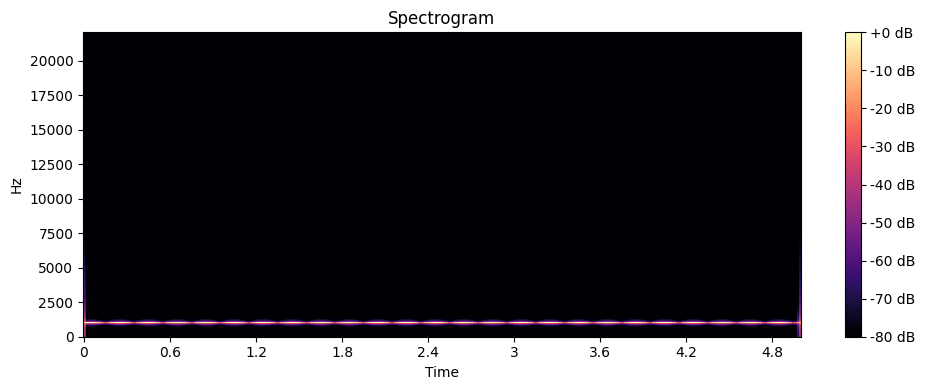

In [15]:
y, sr = librosa.load(audio_path, sr=None)

D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(10,4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

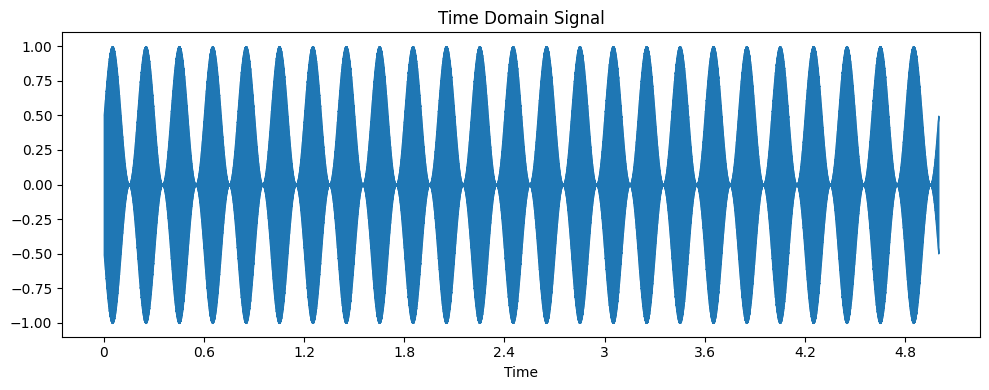

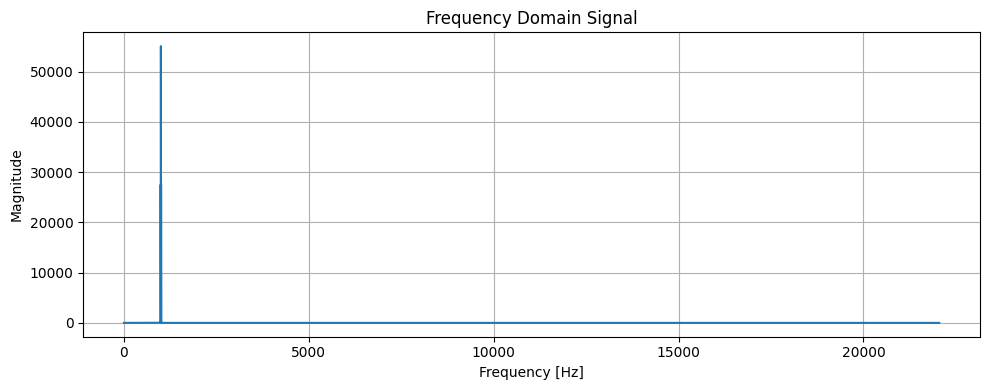

In [16]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Time Domain Signal')
plt.tight_layout()
plt.show()

Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)

plt.figure(figsize=(10, 4))
plt.plot(freqs[:len(freqs)//2], np.abs(Y[:len(Y)//2]))
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

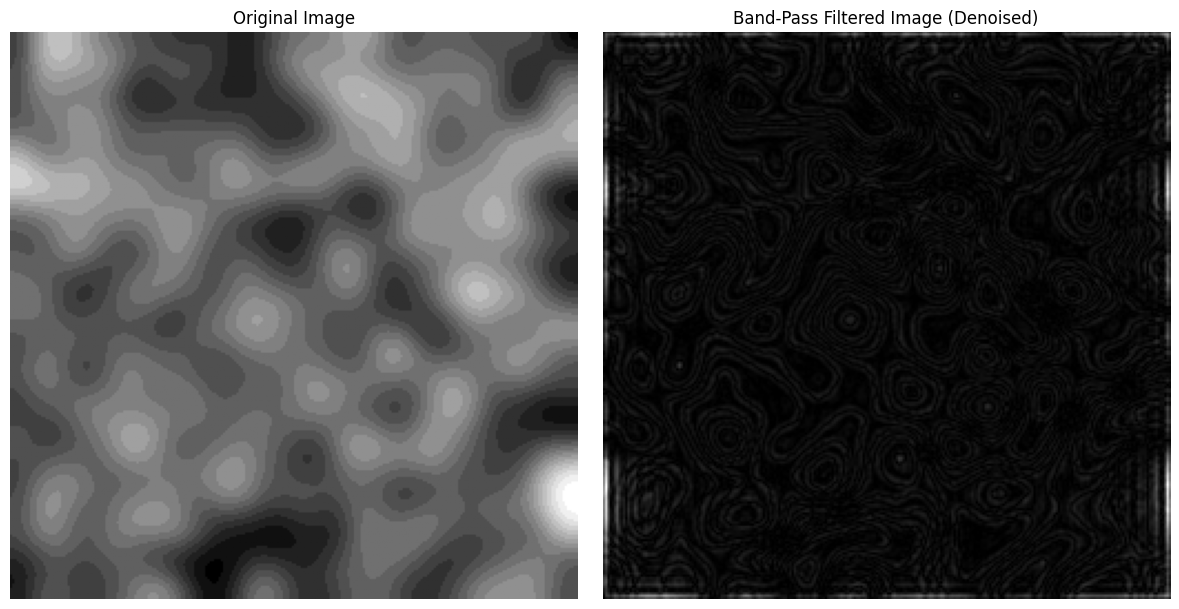

In [17]:

f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

rows, cols = image.shape
crow, ccol = rows // 2, cols // 2


r1 = 20 
r2 = 80  


mask = np.zeros((rows, cols), dtype=np.float32)
cv2.circle(mask, (ccol, crow), r2, 1, thickness=-1)
cv2.circle(mask, (ccol, crow), r1, 0, thickness=-1) 

fshift_bp = fshift * mask

f_ishift = np.fft.ifftshift(fshift_bp)
img_bandpass = np.fft.ifft2(f_ishift)
img_bandpass = np.abs(img_bandpass)


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_bandpass, cmap='gray')
plt.title('Band-Pass Filtered Image (Denoised)')
plt.axis('off')

plt.tight_layout()
plt.show()